<a href="https://colab.research.google.com/github/PeronxD/Python/blob/main/Avaliando_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Esse trabalho tem como objetivo estudar métodos para analisar a parformance de modelos, para isso usei novamente uma base de Churn e modelos de classificações (Árvore de decisão, Regressão Logística, KNN e Naive Bayes). Aqui não estamos interessados em fazer o melhor modelo,apenas estudar como avaliá-los

In [62]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [63]:
import warnings
warnings.filterwarnings("ignore")

Nesse primeiro momento irei apenas tratar a base de dados para a construção dos modelos

In [64]:
dados = pd.read_csv('/content/Customer-Churn.csv')

In [65]:
dados.head()

,Maior65Anos,Conjuge,Dependentes,MesesDeContrato,TelefoneFixo,VariasLinhasTelefonicas,ServicoDeInternet,SegurancaOnline,BackupOnline,SeguroNoDispositivo,SuporteTecnico,TVaCabo,StreamingDeFilmes,TipoDeContrato,PagamentoOnline,FormaDePagamento,ContaMensal,Churn
0,0,Sim,Nao,1,Nao,SemServicoTelefonico,DSL,Nao,Sim,Nao,Nao,Nao,Nao,Mensalmente,Sim,ChequeDigital,29.85,Nao
1,0,Nao,Nao,34,Sim,Nao,DSL,Sim,Nao,Sim,Nao,Nao,Nao,UmAno,Nao,ChequePapel,56.95,Nao
2,0,Nao,Nao,2,Sim,Nao,DSL,Sim,Sim,Nao,Nao,Nao,Nao,Mensalmente,Sim,ChequePapel,53.85,Sim
3,0,Nao,Nao,45,Nao,SemServicoTelefonico,DSL,Sim,Nao,Sim,Sim,Nao,Nao,UmAno,Nao,DebitoEmConta,42.30,Nao
4,0,Nao,Nao,2,Sim,Nao,FibraOptica,Nao,Nao,Nao,Nao,Nao,Nao,Mensalmente,Sim,ChequeDigital,70.70,Sim


In [66]:
traducao_dic = {'Sim': 1,
                'Nao': 0}

dadosmodificados = dados[['Conjuge', 'Dependentes', 'TelefoneFixo', 'PagamentoOnline', 'Churn']].replace(traducao_dic)
dadosmodificados.head()

,Conjuge,Dependentes,TelefoneFixo,PagamentoOnline,Churn
0,1,0,0,1,0
1,0,0,1,0,0
2,0,0,1,1,1
3,0,0,0,0,0
4,0,0,1,1,1


In [67]:
dummie_dados = pd.get_dummies(dados.drop(['Conjuge', 'Dependentes', 'TelefoneFixo', 'PagamentoOnline', 'Churn'],
                axis=1))

In [68]:
dados_final = pd.concat([dadosmodificados, dummie_dados], axis=1)

In [69]:
X = dados_final.drop('Churn', axis = 1)
y = dados_final['Churn']

Importante observar que para esses modelos eu não irei balancear os dados, pois quero olhar as performance em dados desbalanceados.

In [70]:
dados_final.Churn.value_counts()/len(dados_final.Churn) # dados desbalanceados

Churn
0    0.73463
1    0.26537
Name: count, dtype: float64

In [71]:
from sklearn.preprocessing import StandardScaler

In [72]:
norm = StandardScaler()

X_normalizado = norm.fit_transform(X)
X_normalizado

array([[ 1.03453023, -0.65401193, -3.05401039, ...,  1.40641839,
        -0.54480692, -0.5298852 ],
       [-0.96662231, -0.65401193,  0.32743831, ..., -0.71102597,
         1.83551265, -0.5298852 ],
       [-0.96662231, -0.65401193,  0.32743831, ..., -0.71102597,
         1.83551265, -0.5298852 ],
       ...,
       [ 1.03453023,  1.5290241 , -3.05401039, ...,  1.40641839,
        -0.54480692, -0.5298852 ],
       [ 1.03453023, -0.65401193,  0.32743831, ..., -0.71102597,
         1.83551265, -0.5298852 ],
       [-0.96662231, -0.65401193,  0.32743831, ..., -0.71102597,
        -0.54480692,  1.88720123]])

In [73]:
# Dividir o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [74]:
# Inicializar os modelos
models = {
    'Árvore de Decisão': DecisionTreeClassifier(random_state=42),
    'Regressão Logística': LogisticRegression(max_iter=10000, random_state=42),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

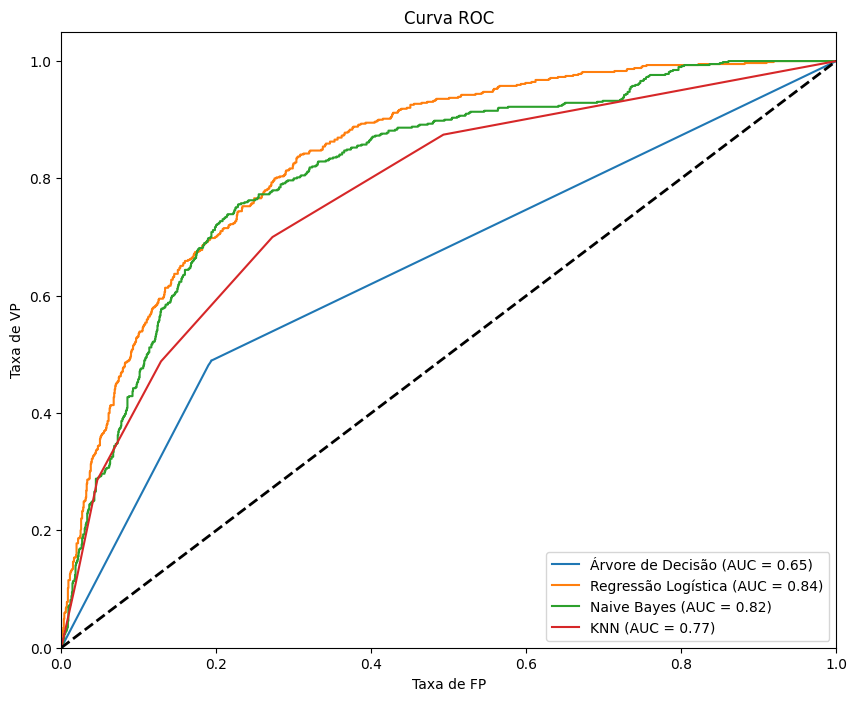

Scores e AUC (com validação cruzada):
                        Score  Score STD       AUC   AUC STD
Árvore de Decisão    0.727530   0.008492  0.659250  0.012768
Regressão Logística  0.802495   0.011823  0.843196  0.013695
Naive Bayes          0.688341   0.008781  0.818674  0.012031
KNN                  0.763451   0.012965  0.777337  0.018066


In [75]:
results_cv = {}
plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)

     # Validação cruzada para AUC-ROC
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

    results_cv[name] = {
        'Score': accuracy_scores.mean(),
        'Score STD': accuracy_scores.std(),
        'AUC': auc_scores.mean(),
        'AUC STD': auc_scores.std()
    }
      # Calcular e plotar a curva ROC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de FP')
plt.ylabel('Taxa de VP')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

results_cv_df = pd.DataFrame(results_cv).T
print("Scores e AUC (com validação cruzada):")
print(results_cv_df)




### Interpretação das Métricas de Avaliação
Analisando os Scores (Acertos/Total), o modelo de Naive Bayes teve o pior desempenho com 68.8%, abaixo da taxa base de 73.4%. Isso indica que, com base apenas no Score, seria melhor supor que todos os clientes não serão churn do que usar o modelo de Naive Bayes, o que também vale para a Árvore de Decisão.

###Importância da AUC
A AUC (Área Sob a Curva ROC) oferece uma visão mais detalhada, pois considera os Falsos Positivos (FP) e os Verdadeiros Positivos (VP). Com essa métrica, o Naive Bayes subiu para a segunda maior AUC, demonstrando melhor capacidade de distinguir entre clientes que irão churnar e os que não irão.

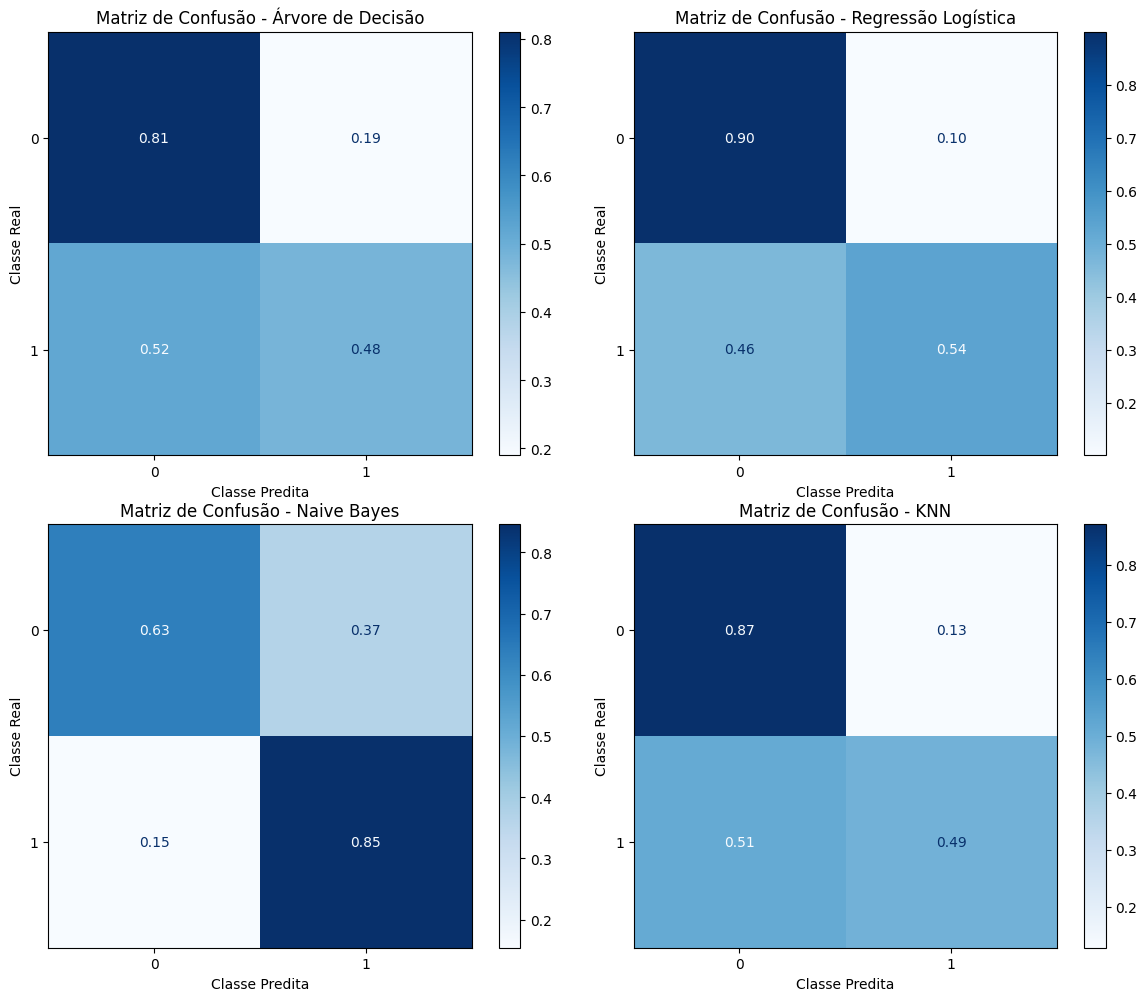

In [82]:
# Plotar matrizes de confusão em um layout 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, model) in zip(axes.ravel(), models.items()):
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)

    # Gerar a matriz de confusão e normalizar
    cm = confusion_matrix(y_test, y_pred_test, normalize='true')

    # Plotar a matriz de confusão
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dados_final['Churn'].unique())
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.2f')
    ax.title.set_text(f'Matriz de Confusão - {name}')
    ax.set_xlabel('Classe Predita')
    ax.set_ylabel('Classe Real')
    ax.grid(False)

plt.tight_layout()
plt.show()

Para entender melhor por que o Naive Bayes apresenta um score geral mais baixo, mas um AUC mais elevado, vamos analisar as matrizes de confusão de cada modelo.

### Análise das Matrizes de Confusão

Observamos que todos os modelos conseguem prever muito bem os não Churns, com uma taxa de acerto de 90%, exceto o Naive Bayes, que apresenta uma taxa de 63%. No entanto, na previsão dos Churns, a maioria dos modelos não se sai tão bem, com uma taxa de acerto de apenas 50%. Além disso, todos os modelos, exceto o Naive Bayes, apresentam uma taxa de falsos negativos elevada, em torno de 50%. Essa situação é comum em bases de dados desbalanceadas.

Por outro lado, o Naive Bayes se comporta de forma diferente. Ele comete mais erros ao prever que um cliente não será um Churn, mas consegue identificar aqueles que serão com uma taxa de acerto de 85%. Além disso, ele apresenta uma taxa de falsos negativos significativamente menor, de apenas 15%.

### Reflexão sobre a Importância da Avaliação do Modelo

Essa análise mostra a importância de avaliar o modelo de acordo com o problema específico que queremos resolver. Em muitos cenários, prever corretamente que um cliente será um Churn é mais crítico do que prever que ele não será. Isso ocorre porque errar ao dizer que um cliente não será um Churn, e ele acabar se tornando, pode gerar um prejuízo significativo, muitas vezes maior do que errar ao prever que um cliente será um Churn, e ele não se tornar.

Portanto, ao selecionar um modelo, é fundamental considerar o impacto dos diferentes tipos de erros no contexto do negócio. O Naive Bayes, apesar de seu score geral mais baixo, pode ser a melhor escolha em situações onde identificar corretamente os clientes que irão deixar a empresa é crucial para mitigar perdas financeiras.

### Conclusão

A análise detalhada das matrizes de confusão revela que, embora o Naive Bayes possa ter um desempenho geral inferior em termos de acurácia, seu desempenho superior em prever churns e reduzir falsos negativos o torna mais valioso em cenários onde os custos associados a clientes que se tornam churns são altos. Isso reforça a necessidade de uma avaliação cuidadosa e contextual dos modelos de machine learning para garantir que eles atendam às necessidades específicas do negócio.

### Avaliação do Benefício de Previsão de Churn vs. Redução de Falsos Negativos
Para entender melhor o impacto de usar um modelo que prevê melhor os churns em comparação com um modelo que erra menos nos falsos negativos, precisamos considerar o equilíbrio entre esses aspectos e como eles afetam nosso negócio.

###Contextualizando o Problema de Negócio
Vamos supor que nossa empresa deseja realizar uma campanha para reduzir o churn dos clientes. Essa campanha envolve custos e lucros associados às decisões de manter ou não um cliente:

O custo para tentar manter um cliente é duas vezes maior do que o lucro de mantê-lo.
O custo de atrair novos clientes é significativamente maior do que o custo de tentar manter os existentes.
Se um cliente permanecer na empresa após a campanha, o lucro gerado supera os custos da campanha.
Escolha do Melhor Modelo
Para definir qual modelo é mais adequado baseado nas condições de negócio, usaremos o custo esperado, que pondera os custos e benefícios dos verdadeiros positivos (VP) e falsos positivos (FP). Em seguida, criaremos um gráfico que mostra a proporção de clientes sobre os quais aplicamos o modelo, ordenados de forma decrescente pelo score dos modelos, e a relação do lucro esperado.

In [84]:
# Definir lucros e prejuízos
lucro_vp = 1  # Lucro por verdadeiro positivo
prejuizo_fp = 2  # Prejuízo por falso positivo

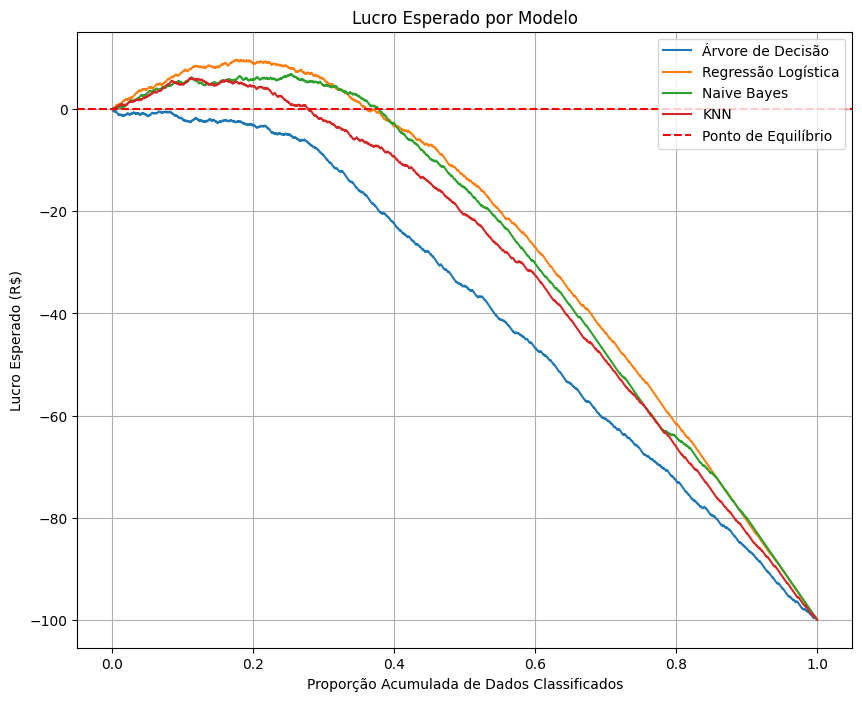

In [86]:
# Função para calcular o lucro esperado com lucros e prejuízos definidos
def calcular_lucro_esperado(y_true, y_pred_proba, lucro_vp, prejuizo_fp):
    data = pd.DataFrame({'true': y_true, 'probs': y_pred_proba})
    data = data.sort_values(by='probs', ascending=False)
    data['cumulative_data'] = np.arange(1, len(data) + 1) / len(data)
    data['cumulative_positive'] = np.cumsum(data['true']) / np.sum(data['true'])
    data['cumulative_negative'] = np.cumsum(1 - data['true']) / np.sum(1 - data['true'])

    lucro_esperado = (data['cumulative_positive'] * lucro_vp -
                      data['cumulative_data'] * prejuizo_fp)
    return lucro_esperado * 100  # Converter para reais

# Plotar o gráfico de lucro esperado por modelo
plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.predict(X_test)

    lucro = calcular_lucro_esperado(y_test, y_prob, lucro_vp, prejuizo_fp)
    proporcao_acumulada = np.arange(1, len(lucro) + 1) / len(lucro)
    plt.plot(proporcao_acumulada, lucro, label=name)

plt.axhline(y=0, color='r', linestyle='--', label='Ponto de Equilíbrio')
plt.xlabel('Proporção Acumulada de Dados Classificados')
plt.ylabel('Lucro Esperado (R$)')
plt.title('Lucro Esperado por Modelo')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

### Interpretação do Gráfico

Este gráfico nos permite visualizar o lucro esperado em função da proporção de clientes classificados como churns, ordenados pela probabilidade prevista de churn. Ele nos mostra o impacto financeiro de diferentes "faixas de corte" e ajuda a decidir qual modelo proporciona o melhor equilíbrio entre custo e benefício.

- **Linha de Ponto de Equilíbrio**: Representa o ponto onde os custos e benefícios se igualam.
- **Proporção Acumulada de Dados Classificados**: Mostra a fração de clientes classificados como churn em ordem decrescente de probabilidade.
- **Lucro Esperado (R$)**: Representa o lucro esperado em reais considerando as condições de custo e benefício estabelecidas.

### Conclusão

Ao analisar os gráficos de lucro esperado, percebemos que, embora o Naive Bayes apresente algumas vantagens sobre a Regressão Logística, como uma maior taxa de acertos na previsão de churn, a Regressão Logística se mostra mais eficaz no contexto do problema proposto. Utilizando cerca de 20% dos dados, a Regressão Logística atinge o lucro máximo, tornando-se a opção mais ideal.

Essa conclusão é baseada na ponderação de custos e benefícios de manter os clientes, demonstrando a importância de considerar as especificidades do negócio ao escolher um modelo. Dependendo das prioridades e dos impactos financeiros de diferentes tipos de erros, o modelo mais adequado pode variar. Neste caso, a Regressão Logística equilibra melhor os custos e benefícios, proporcionando maior lucratividade para a empresa ao abordar o problema do churn de clientes.